## Import

In [82]:
import os
import torch
import pandas as pd
from datasets import Dataset
from transformers import AutoModelForSequenceClassification, Trainer, AutoTokenizer
import numpy as np
import torch
from sklearn.metrics import accuracy_score, f1_score,classification_report
import pandas as pd
from transformers import AutoModelForSequenceClassification, Trainer
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, classification_report
from datasets import Dataset
import numpy as np
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer



In [83]:
# Cuda pruefen
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cuda device


## import der gelablten daten und testsplit

Gelabelte Daten importieren und mergen

In [84]:
DATA_PATH = '../../data/processed/'

In [85]:
# CSV-Dateien laden
df_posts_old = pd.read_csv(DATA_PATH + "labeled_posts.csv").rename(columns={"post_id": "id"})
df_comments_old = pd.read_csv(DATA_PATH + "labeled_comments.csv").rename(columns={"comment_id": "id"})
df_new_posts = pd.read_csv(DATA_PATH + "labeled_post.csv").rename(columns={"post_id": "id"})
df_new_comments = pd.read_csv(DATA_PATH + "labeled_comment.csv").rename(columns={"comment_id": "id"})

# Post- und Comment-Daten separat zusammenführen
df_all_posts = pd.concat([df_posts_old, df_new_posts], ignore_index=True)
df_all_comments = pd.concat([df_comments_old, df_new_comments], ignore_index=True)

# Vereinheitlichen & vorbereiten
df_all_posts = df_all_posts[['id', 'text', 'label']].dropna()
df_all_comments = df_all_comments[['id', 'text', 'label']].dropna()

df_all_posts['label'] = pd.to_numeric(df_all_posts['label'], errors='coerce').dropna().astype(int)
df_all_comments['label'] = pd.to_numeric(df_all_comments['label'], errors='coerce').dropna().astype(int)

print(f"✅ Posts: {len(df_all_posts)} Beispiele")
print(df_all_posts["label"].value_counts())

print(f"\n✅ Comments: {len(df_all_comments)} Beispiele")
print(df_all_comments["label"].value_counts())


✅ Posts: 298 Beispiele
label
1    162
0     95
2     41
Name: count, dtype: int64

✅ Comments: 276 Beispiele
label
1    138
0     91
2     47
Name: count, dtype: int64


train test split

In [86]:
def stratified_split(df, test_size=0.2, val_size=0.25, seed=42):
    trainval_df, test_df = train_test_split(
        df,
        test_size=test_size,
        stratify=df["label"],
        random_state=seed
    )
    train_df, val_df = train_test_split(
        trainval_df,
        test_size=val_size,
        stratify=trainval_df["label"],
        random_state=seed
    )
    return train_df.reset_index(drop=True), val_df.reset_index(drop=True), test_df.reset_index(drop=True)

In [87]:
train_posts, val_posts, test_posts = stratified_split(df_all_posts)
train_comments, val_comments, test_comments = stratified_split(df_all_comments)


## Modelle

In [88]:
# Modelle definieren
HF_MODELS = {
    "deberta": "microsoft/deberta-v3-base",
    "cryptobert": "ElKulako/cryptobert",
    "finbert": "yiyanghkust/finbert-tone",
    "roberta": "cardiffnlp/twitter-roberta-base-sentiment"
}

CLASSIC_MODELS = {
    "vader": SentimentIntensityAnalyzer(),
    "textblob": "textblob"
}


In [89]:
# Ergebniscontainer für Klassifikationsreports
classification_reports_posts = {}
classification_reports_comments = {}

# Evaluation
for dataset_name, current_test_df in [("posts", test_posts), ("comments", test_comments)]:
    print(f"\nKlassifikationsreport für {dataset_name.upper()}:\n{'='*60}")

    # Temporärer Ergebniscontainer je Datensatz
    temp_reports = {}

    # HuggingFace Modelle
    for name, model_name in HF_MODELS.items():
        print(f"\n{name.upper()} Modell:")

        tokenizer = AutoTokenizer.from_pretrained(model_name)
        model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

        test_dataset = Dataset.from_pandas(current_test_df)
        tokenized_test = test_dataset.map(lambda x: tokenizer(x['text'], truncation=True, padding='max_length', max_length=256), batched=True)
        tokenized_test = tokenized_test.rename_column("label", "labels")
        tokenized_test.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

        trainer = Trainer(model=model, tokenizer=tokenizer)
        predictions = trainer.predict(tokenized_test)

        y_pred = np.argmax(predictions.predictions, axis=1)
        y_true = predictions.label_ids

        # CryptoBERT Mapping (wie zuvor definiert)
        if name == "cryptobert":
            label_mapping = {2: 0, 1: 1, 0: 2}
            y_pred = [label_mapping[p] for p in y_pred]

        # Klassifikationsreport speichern
        report = classification_report(
            y_true, y_pred,
            target_names=['bullish', 'neutral', 'bearish'],
            output_dict=True
        )

        temp_reports[name] = report

    # Klassische Modelle
    for name, model_obj in CLASSIC_MODELS.items():
        print(f"\n{name.upper()} Modell:")
        preds = []
        for text in current_test_df["text"]:
            if name == "vader":
                score = model_obj.polarity_scores(text)["compound"]
                preds.append(0 if score >= 0.05 else 2 if score <= -0.05 else 1)

            elif name == "textblob":
                polarity = TextBlob(text).sentiment.polarity
                preds.append(0 if polarity >= 0.05 else 2 if polarity <= -0.05 else 1)

        # Klassifikationsreport speichern
        report = classification_report(
            current_test_df["label"], preds,
            target_names=['bullish', 'neutral', 'bearish'],
            output_dict=True
        )

        temp_reports[name] = report

    # Reports endgültig in den jeweiligen Container speichern
    if dataset_name == "posts":
        classification_reports_posts = temp_reports
    else:
        classification_reports_comments = temp_reports



Klassifikationsreport für POSTS:

DEBERTA Modell:


c:\Users\hp\anaconda3\envs\crypto_nlp\lib\site-packages\transformers\convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 60/60 [00:00<00:00, 3481.23 examples/s]
C:\Users\hp\AppData\Local\Temp\ipykernel_36064\4063060532.py:24: FutureWar

c:\Users\hp\anaconda3\envs\crypto_nlp\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\hp\anaconda3\envs\crypto_nlp\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\hp\anaconda3\envs\crypto_nlp\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



CRYPTOBERT Modell:


Map: 100%|██████████| 60/60 [00:00<00:00, 3977.91 examples/s]
C:\Users\hp\AppData\Local\Temp\ipykernel_36064\4063060532.py:24: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, tokenizer=tokenizer)



FINBERT Modell:


Map: 100%|██████████| 60/60 [00:00<00:00, 4604.49 examples/s]
C:\Users\hp\AppData\Local\Temp\ipykernel_36064\4063060532.py:24: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, tokenizer=tokenizer)



ROBERTA Modell:


Map: 100%|██████████| 60/60 [00:00<00:00, 3514.39 examples/s]
C:\Users\hp\AppData\Local\Temp\ipykernel_36064\4063060532.py:24: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, tokenizer=tokenizer)



VADER Modell:

TEXTBLOB Modell:

Klassifikationsreport für COMMENTS:

DEBERTA Modell:


c:\Users\hp\anaconda3\envs\crypto_nlp\lib\site-packages\transformers\convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 56/56 [00:00<00:00, 5202.35 examples/s]
C:\Users\hp\AppData\Local\Temp\ipykernel_36064\4063060532.py:24: FutureWar

c:\Users\hp\anaconda3\envs\crypto_nlp\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\hp\anaconda3\envs\crypto_nlp\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\hp\anaconda3\envs\crypto_nlp\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



CRYPTOBERT Modell:


Map: 100%|██████████| 56/56 [00:00<00:00, 6924.35 examples/s]
C:\Users\hp\AppData\Local\Temp\ipykernel_36064\4063060532.py:24: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, tokenizer=tokenizer)



FINBERT Modell:


Map: 100%|██████████| 56/56 [00:00<00:00, 6980.95 examples/s]
C:\Users\hp\AppData\Local\Temp\ipykernel_36064\4063060532.py:24: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, tokenizer=tokenizer)



ROBERTA Modell:


Map: 100%|██████████| 56/56 [00:00<00:00, 6882.36 examples/s]
C:\Users\hp\AppData\Local\Temp\ipykernel_36064\4063060532.py:24: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, tokenizer=tokenizer)



VADER Modell:

TEXTBLOB Modell:


## Plot

In [90]:
# Hilfsfunktion zur Extraktion der F1-Scores
def extract_f1_scores(classification_reports):
    f1_data = {}
    for model, report in classification_reports.items():
        f1_data[model] = {
            "bullish": report["bullish"]["f1-score"],
            "neutral": report["neutral"]["f1-score"],
            "bearish": report["bearish"]["f1-score"]
        }
    return f1_data

# F1-Scores extrahieren
f1_posts = extract_f1_scores(classification_reports_posts)
f1_comments = extract_f1_scores(classification_reports_comments)

# Ausgabe
print("📊 F1-Scores pro Klasse – POSTS")
for model, scores in f1_posts.items():
    print(f"\n{model.upper()}:")
    for cls, score in scores.items():
        print(f"  {cls}: {score:.4f}")

print("\n" + "="*60)
print("📊 F1-Scores pro Klasse – COMMENTS")
for model, scores in f1_comments.items():
    print(f"\n{model.upper()}:")
    for cls, score in scores.items():
        print(f"  {cls}: {score:.4f}")


📊 F1-Scores pro Klasse – POSTS

DEBERTA:
  bullish: 0.4810
  neutral: 0.0000
  bearish: 0.0000

CRYPTOBERT:
  bullish: 0.2500
  neutral: 0.4348
  bearish: 0.0000

FINBERT:
  bullish: 0.5075
  neutral: 0.1081
  bearish: 0.5000

ROBERTA:
  bullish: 0.0000
  neutral: 0.5507
  bearish: 0.1250

VADER:
  bullish: 0.4262
  neutral: 0.1860
  bearish: 0.6250

TEXTBLOB:
  bullish: 0.5091
  neutral: 0.4400
  bearish: 0.5333

📊 F1-Scores pro Klasse – COMMENTS

DEBERTA:
  bullish: 0.4865
  neutral: 0.0000
  bearish: 0.0000

CRYPTOBERT:
  bullish: 0.5143
  neutral: 0.5806
  bearish: 0.1333

FINBERT:
  bullish: 0.4516
  neutral: 0.1250
  bearish: 0.3333

ROBERTA:
  bullish: 0.1395
  neutral: 0.4906
  bearish: 0.1250

VADER:
  bullish: 0.4878
  neutral: 0.4186
  bearish: 0.3571

TEXTBLOB:
  bullish: 0.4615
  neutral: 0.5490
  bearish: 0.3636


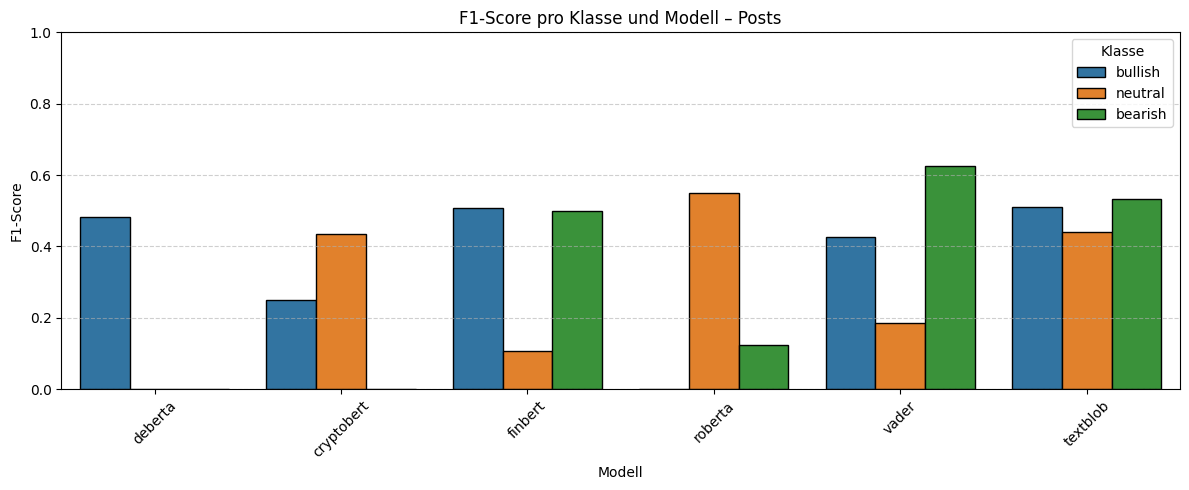

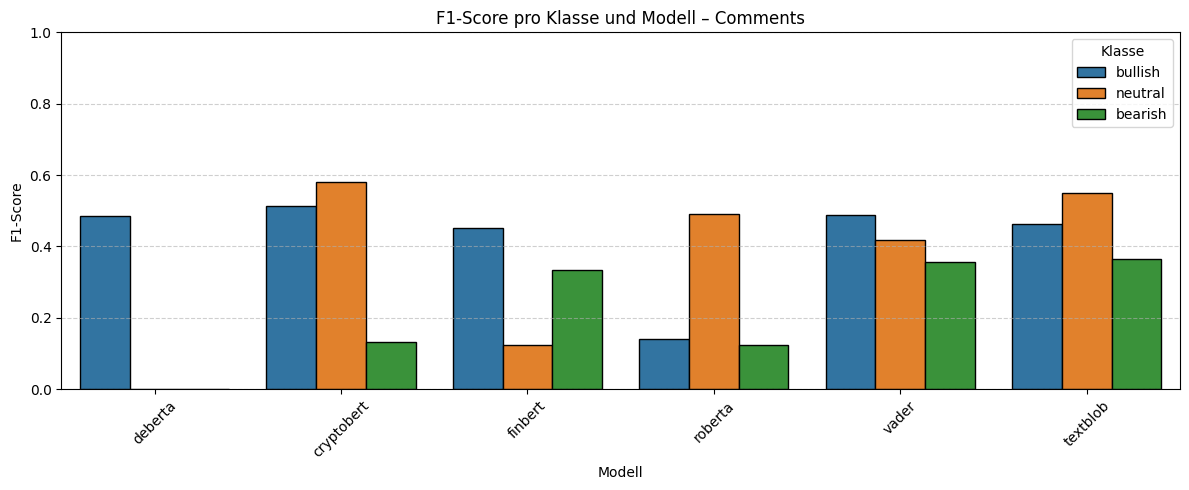

In [91]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# In DataFrames umwandeln
df_posts = pd.DataFrame(f1_posts).T.reset_index().rename(columns={"index": "model"})
df_comments = pd.DataFrame(f1_comments).T.reset_index().rename(columns={"index": "model"})

# Melt für Plots – nur über die Klassen (nicht über "type" oder sonstiges)
df_posts_melted = df_posts.melt(id_vars=["model"], 
                                value_vars=["bullish", "neutral", "bearish"],
                                var_name="class", value_name="f1_score")

df_comments_melted = df_comments.melt(id_vars=["model"], 
                                      value_vars=["bullish", "neutral", "bearish"],
                                      var_name="class", value_name="f1_score")

# Plot: POSTS
plt.figure(figsize=(12, 5))
sns.barplot(data=df_posts_melted, x="model", y="f1_score", hue="class", edgecolor="black")
plt.title("F1-Score pro Klasse und Modell – Posts")
plt.ylabel("F1-Score")
plt.xlabel("Modell")
plt.ylim(0, 1)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.legend(title="Klasse")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot: COMMENTS
plt.figure(figsize=(12, 5))
sns.barplot(data=df_comments_melted, x="model", y="f1_score", hue="class", edgecolor="black")
plt.title("F1-Score pro Klasse und Modell – Comments")
plt.ylabel("F1-Score")
plt.xlabel("Modell")
plt.ylim(0, 1)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.legend(title="Klasse")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


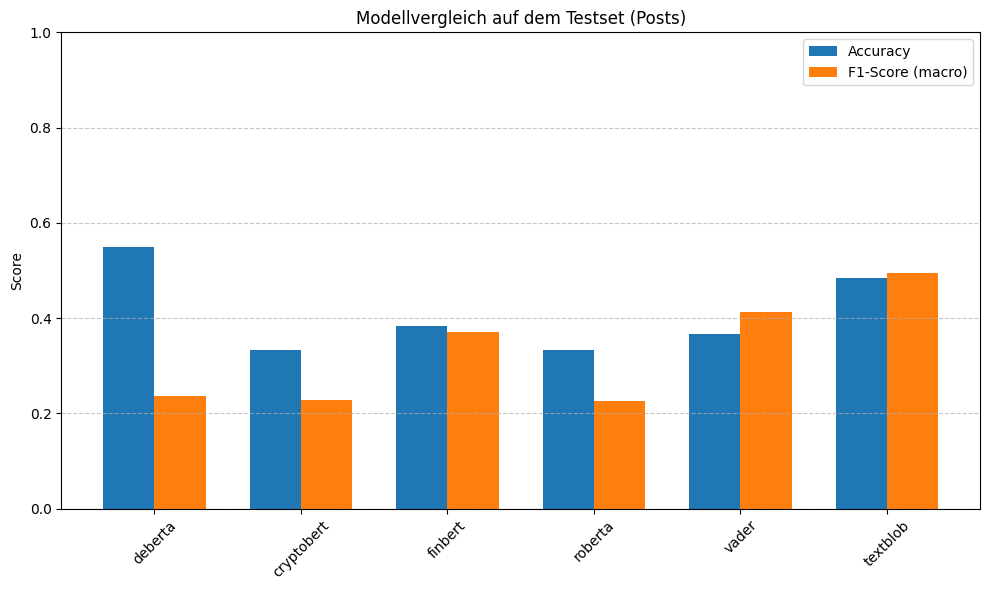

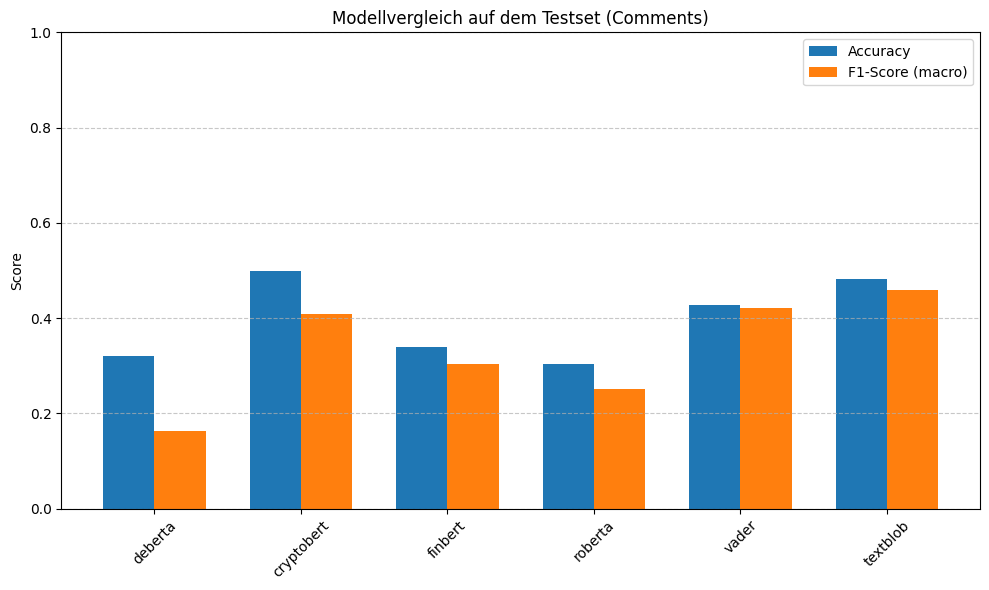

In [92]:
plot_results(plot_results_data_posts, title_suffix="(Posts)")
plot_results(plot_results_data_comments, title_suffix="(Comments)")


## Export

Export von CryptoBert (Elkulako)

In [93]:
import os
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Speicherpfad
cryptobert_path = "../../models/experiments/cryptobert_comments/"
os.makedirs(cryptobert_path, exist_ok=True)

# Modell laden
model_name = "ElKulako/cryptobert"
cryptobert_model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)
cryptobert_tokenizer = AutoTokenizer.from_pretrained(model_name)

# Speichern
cryptobert_model.save_pretrained(cryptobert_path)
cryptobert_tokenizer.save_pretrained(cryptobert_path)

print("✅ CryptoBERT gespeichert unter:", cryptobert_path)


✅ CryptoBERT gespeichert unter: ../../models/experiments/cryptobert_comments/


Export FinBert 

In [94]:
# Speicherpfad
finbert_path = "../../models/experiments/finbert_posts/"
os.makedirs(finbert_path, exist_ok=True)

# Modell laden
finbert_model = AutoModelForSequenceClassification.from_pretrained("yiyanghkust/finbert-tone", num_labels=3)
finbert_tokenizer = AutoTokenizer.from_pretrained("yiyanghkust/finbert-tone")

# Speichern
finbert_model.save_pretrained(finbert_path)
finbert_tokenizer.save_pretrained(finbert_path)

print("✅ FinBERT gespeichert unter:", finbert_path)


✅ FinBERT gespeichert unter: ../../models/experiments/finbert_posts/
